**<h2>Computing Generalisation error** 

Importing relevant packages from PyTorch

In [1]:
"""
Created on Sat May 15 17:34:55 2021
@author: Katerina Karoni
"""
import torch                        # Torch is an open-source machine learning library, a scientific computing framework,
                                       #and a script language
import torch.nn as nn
import torch.nn.functional as F     # Convolution Functions
import torch.optim as optim         # Package implementing various optimization algorithms
import matplotlib.pyplot as plt
from torchvision import datasets, transforms  #The torchvision package consists of popular datasets, model 
                                              #architectures, and common image transformations for computer vision
from torch.utils.data import DataLoader, TensorDataset       #Data loading utility class
from torch import Tensor
import pandas as pd

import numpy as np
import random
import os
import ase
from ase import Atoms
from ase.io import read

import time

**<h3>Training and Test Set**

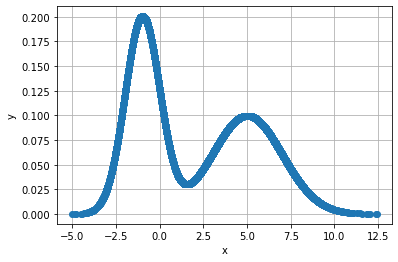

In [2]:
mu, sigma = 0, 1 # mean and standard deviation of normal distribution

# # Double well potential
# Eo = 2*10**(-4) #Hartree
# c  = 0.045

#x  = np.linspace(-4, 4, num=1500) #np.random.uniform(-6,6,1000) #np.random.normal(mu, sigma, 2500) #np.random.exponential(0.63,size=2500)
# x  = np.reshape(x,(len(x),1))

# V  = (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(x-mu)**2/(2*sigma**2))   #Eo * (c * x**4 - x**2) 
# V  = np.reshape(V,(len(V),1))

N=10000
mu1, sigma1 = 5, 2
mu2, sigma2 = -1, 1
x1 = np.random.normal(mu1, sigma1, N)
x2 = np.random.normal(mu2, sigma2, N)
x = np.concatenate([x1, x2])
x  = np.reshape(x,(len(x),1))


V = 0.5*(1/np.sqrt(2*np.pi*sigma1**2))*np.exp(-(x-mu1)**2/(2*sigma1**2)) + 0.5*(1/np.sqrt(2*np.pi*sigma2**2))*np.exp(-(x-mu2)**2/(2*sigma2**2))
V  = np.reshape(V,(len(V),1))

# shuffler = np.random.permutation(len(V))

# x = x[shuffler]

# V = V[shuffler]

test_set = torch.FloatTensor(x)
test_labels = torch.FloatTensor(V)


plt.plot(x,V,'o')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

In [3]:
# data_size            = np.shape(V)[0]       
# training_set_size    = data_size - 500

# # # Computing variance and mean on the training data only!
# # x_train = x[:training_set_size]
# # var  = np.std(x_train)
# # mean = np.mean(x_train)

# # normalize all data (training and test), using training set mean and variance
# data_set = x#(x-mean)/var 


# data_set = torch.FloatTensor(data_set)          


# # V_train  = V[:training_set_size]
# # var_lab  = np.std(V_train)
# # mean_lab = np.mean(V_train)

# labels   = V #(V-mean_lab)/var_lab
# labels = torch.FloatTensor(V)        



# # Splitting the adataset into training and test set
# training_set         = data_set[:training_set_size]
# test_set             = data_set[training_set_size:]

# train_labels         = labels[:training_set_size]
# test_labels          = labels[training_set_size:]

# # Dataset
# dataset = TensorDataset(training_set, train_labels)
# #print(dataset[0])

# # Creating the batches
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=training_set_size//8,
#                                            shuffle=True, num_workers=2, drop_last=False)



In [4]:
def generate_data():
    
    N=500
    mu1, sigma1 = 5, 2
    mu2, sigma2 = -1, 1
    x1 = np.random.normal(mu1, sigma1, N)
    x2 = np.random.normal(mu2, sigma2, N)
    x = np.concatenate([x1, x2])
    x  = np.reshape(x,(len(x),1))
    V = 0.5*(1/np.sqrt(2*np.pi*sigma1**2))*np.exp(-(x-mu1)**2/(2*sigma1**2)) + 0.5*(1/np.sqrt(2*np.pi*sigma2**2))*np.exp(-(x-mu2)**2/(2*sigma2**2))
    V  = np.reshape(V,(len(V),1))
    
    data_size            = np.shape(V)[0]       
    data_set = x

    data_set = torch.FloatTensor(data_set)          

    labels   = V 
    labels = torch.FloatTensor(V)        

    training_set         = data_set
    train_labels         = labels

    # Dataset
    dataset = TensorDataset(training_set, train_labels)

    # Creating the batches
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=data_size//10,
                                               shuffle=True, num_workers=2, drop_last=False)
    return data_set, labels,dataloader

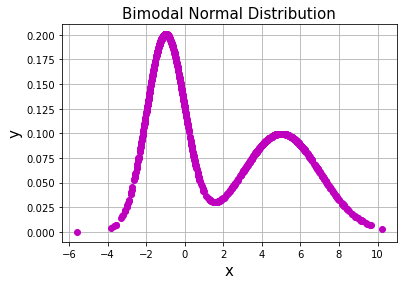

In [5]:
data       = generate_data()
data_set   = data[0]
labels     = data[1]
dataloader = data[2]

plt.plot(data_set,labels,'om')
plt.grid()
plt.xlabel('x',fontsize=15)
plt.ylabel('y',fontsize=15)
plt.title('Bimodal Normal Distribution',fontsize=15)
plt.savefig('Bimodal_Norma_Distribution')

**<h3> Building Neural Network Architecture**

In [6]:
class BPNN(nn.Module):
    def __init__(self):
        super(BPNN, self).__init__()
        self.fc1 = nn.Linear(1, 30)        # where fc stands for fully connected 
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, 30)
        self.fc_out = nn.Linear(30, 1)      # should this be defined here, given that we are not trying to optimise
        
    def forward(self, x,train = True):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
#        x = torch.tanh(self.fc3(x))
        x = torch.sigmoid(self.fc_out(x))
#         x = torch.reshape(x,[1])
        return x


**<h3>Training the Neural Network**

In [7]:
def training(dataloader):
    torch.use_deterministic_algorithms(True)
    seed = 3
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    net = BPNN()
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    #optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.01)
    
    nepochs = 800
    losss = np.zeros(nepochs)
    for epoch in range(nepochs):  # loop over the dataset multiple times

        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)        
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            losss[epoch] = loss
#            print('[%d, %5d] loss: %.15f' %
#                      (epoch + 1, i + 1, loss))

    print('Finished Training')
    return losss, nepochs, net

**<h3>Plotting loss and prediction vs actual label**

In [8]:
def plot_loss(nepochs, losss,i):
    plt.plot(list(range(nepochs)),losss)
    plt.yscale('log')
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Average training loss per epoch')
    plt.show()
#    plt.savefig('loss_{0}'.format(i))
#    return

In [9]:
def plot_prediction(test_set,test_labels,net,i):
    prediction = np.zeros(np.shape(test_labels)[0])
    for j in range(np.shape(test_set)[0]):
        prediction[j] = net(test_set[j])#[0]
    prediction = np.reshape(prediction,(len(prediction),1))
    
    plt.plot(test_set,test_labels, 'om',label = '$\pi(x)$')
    plt.plot(test_set,prediction, 'o', color='blue', label = '$\hat{\pi}(x)$')
    plt.grid()
#    plt.ticklabel_format(axis="y", style="plain")
    plt.title('Test set predictions vs actual labels')
    plt.legend()
    plt.show()
#    plt.savefig('pred_vs_lab{0}'.format(i))
    return prediction

**<h3>Computing Kullback Leibler Divergence**

In [10]:
# def kl_divergence(p, q):
#     kl_div = 0
#     for i in range(len(p)):
#         if p[i] != 0:
#             kl_div = kl_div + p[i] * np.log(p[i]/q[i]) 
#         else:
#             print('zero')
#     return kl_div

In [11]:
def kl_divergence(p, q):
    kl_div = 0
    for i in range(len(p)):
        if p[i] != 0:
            kl_div = kl_div + np.log(p[i]/q[i]) 
        else:
            print('zero')
    return kl_div/len(p)

In [12]:
def mean_sq_error(p, q):
    mse = 0
    for i in range(len(p)):
        mse = mse + (p[i]-q[i])**2
    mse = mse/len(p)
    return mse

**<h3>Computing Normalisation Constant**

In [13]:
def normalisation_const(net):
    Z  = 0
    num_points = 20000
    minimum    = -5
    maximum    = 12.5
    x  = np.linspace(minimum, maximum, num=num_points)
    x  = np.reshape(x,(len(x),1))
    x = torch.FloatTensor(x)
    dx = (12.5 + 5)/(num_points-1)
    for i in range(num_points-1):
        Z  = Z + net(x[i])*dx
    return float(Z)

**<h3>Main loop - Computing generalisation error**

Finished Training
74.22096610069275


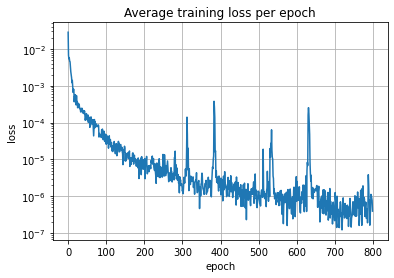

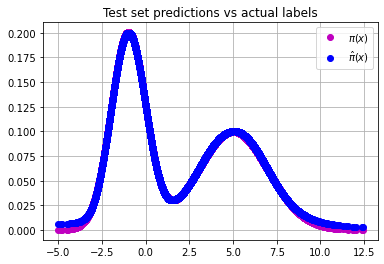

0 0.010319466427297504
0 8.057750937763257e-06
Finished Training
90.10817790031433


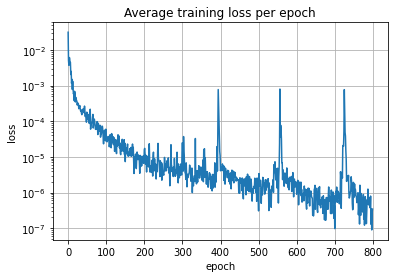

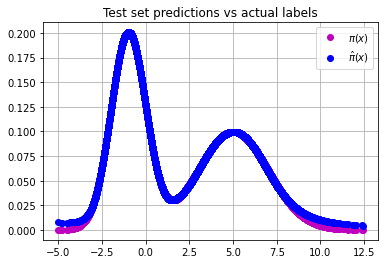

1 0.01595349835430474
1 1.311828313001737e-05
Finished Training
91.9294421672821


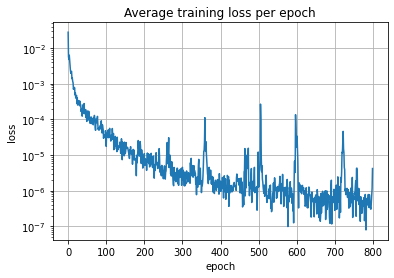

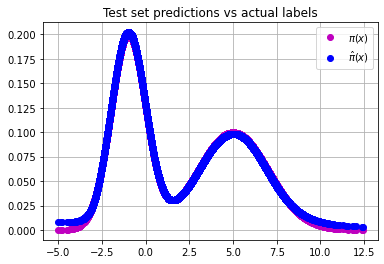

2 0.012707813668200209
2 5.960264118492559e-06
Finished Training
91.18947100639343


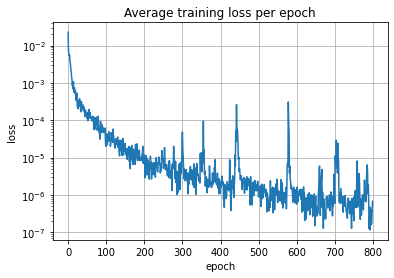

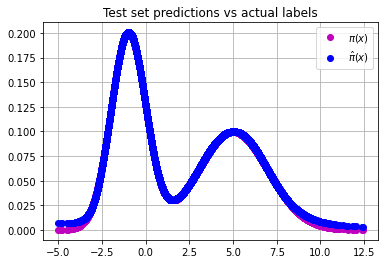

3 0.011699587571166556
3 8.46923617973189e-06
Finished Training
90.38819193840027


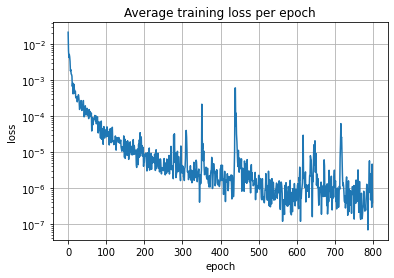

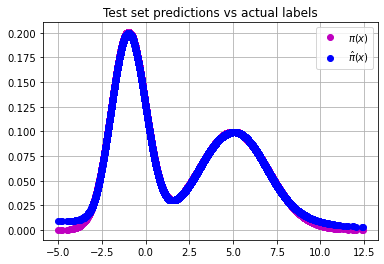

4 0.01395692555154951
4 9.838272225229786e-06
Finished Training
90.38716173171997


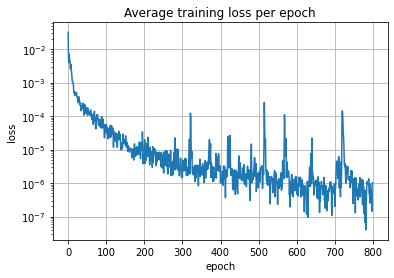

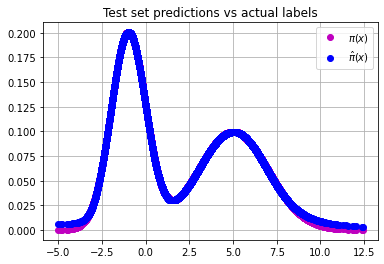

5 0.01136649843988179
5 6.795176033900786e-06
Finished Training
107.7781310081482


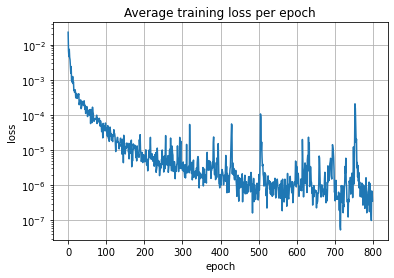

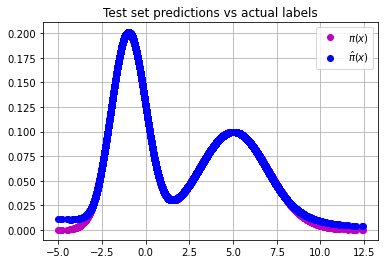

6 0.017034099658013023
6 1.2479447735311664e-05


In [ ]:
niters = 250
kl_div = np.zeros(niters)
mse    = np.zeros(niters)

for i in range(niters):
    data       = generate_data()
    data_set   = data[0]; labels = data[1]
    dataloader = data[2]
    t = time.time()
    dat = training(dataloader)
    elapsed = time.time() - t
    print(elapsed)
    losss = dat[0]; nepochs = dat[1]; net = dat[2];
    plot_loss(nepochs, losss,i)
    prediction = plot_prediction(test_set,test_labels,net,i)
    Z     =   normalisation_const(net)
    prediction = prediction / Z
#    pred = np.copy(prediction)

#     for k in range(len(prediction)):
#         if prediction[k] == 0:
# #            print('zero prediction')
#             prediction[k] = 10**(-20) 

    kl_div[i] = kl_divergence(V,prediction)
    mse[i]    = mean_sq_error(V,prediction)
    print(i,kl_div[i])
    print(i,mse[i])

In [ ]:
prediction = np.zeros(np.shape(test_labels)[0])
for j in range(np.shape(test_set)[0]):
    prediction[j] = net(test_set[j])#[0]
prediction = np.reshape(prediction,(len(prediction),1))
    
plt.plot(test_set,test_labels, 'om',label = 'Target $\pi(x)$')
plt.plot(test_set,prediction, 'o', color='blue', label = 'Prediction $\hat{\pi}(x)$')
plt.grid()
#    plt.ticklabel_format(axis="y", style="plain")
plt.title('Test set predictions vs actual labels')
plt.legend()
#plt.show()
plt.savefig('pred_vs_lab'.format(i))

In [ ]:
prediction = np.zeros(np.shape(labels)[0])
for j in range(np.shape(data_set)[0]):
    prediction[j] = net(torch.FloatTensor(data_set[j]))#[0]
prediction = np.reshape(prediction,(len(prediction),1))
    
plt.plot(data_set,labels, 'om',label = '$\pi(x)$')
plt.plot(data_set,prediction, 'o', color='blue', label = '$\hat{\pi}(x)$')
plt.grid()
#    plt.ticklabel_format(axis="y", style="plain")
plt.title('Training set predictions vs actual labels')
plt.legend()
plt.show()
#plt.savefig('pred_vs_lab{0}'.format(i))

In [ ]:
print(np.sum(kl_div)/len(kl_div))

In [187]:
#kl_div30 = kl_div
#mse_30 = mse

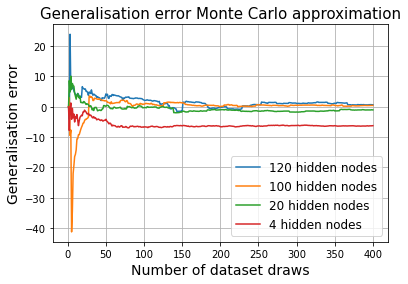

In [177]:
# ge120 = np.zeros(len(kl_div120))
# ge100 = np.zeros(len(kl_div100))
ge30 = np.zeros(len(kl_div30))
# ge20 = np.zeros(len(kl_div20))
# ge4 = np.zeros(len(kl_div4))
for i in range(len(kl_div20)):
#     ge120[i] = sum(kl_div120[:i])/(i+1)
#     ge100[i] = sum(kl_div100[:i])/(i+1)
     ge30[i] = sum(kl_div30[:i])/(i+1)
#     ge20[i] = sum(kl_div20[:i])/(i+1)
#     ge4[i] = sum(kl_div4[:i])/(i+1)
    
i = np.linspace(1,len(kl_div30),len(kl_div30))
# plt.plot(i,ge120,label = '120 hidden nodes')#,color='b')
# plt.plot(i,ge100,label = '100 hidden nodes')#,color='orange')
plt.plot(i,ge30,label = '30 hidden nodes')#,color='g')
# plt.plot(i,ge20,label = '20 hidden nodes')#,color='g')
# plt.plot(i,ge4,label = '4 hidden nodes')#,color='g')
plt.grid()
plt.xlabel('Number of dataset draws',fontsize = 14)
plt.ylabel('Generalisation error',fontsize = 14)
plt.title('Generalisation error Monte Carlo approximation',fontsize = 15)
plt.legend(fontsize = 12)
plt.savefig('Generalization_error_Monte_Carlo_approximation_30_60_90_continuousKLdiv')


In [178]:
print(ge100[:10])

[  0.           2.94585561  -9.49466729  -7.67460107 -41.30137689
 -34.48898157 -22.05119099 -19.44716522 -16.44042692 -15.7057451 ]


In [179]:
#kl_div5 = np.hstack((kl_div_5,kl_div))

In [181]:
print(np.shape(kl_div5))
print(np.shape(kl_div10))

In [183]:
print(np.sum(kl_div10)/len(kl_div10))

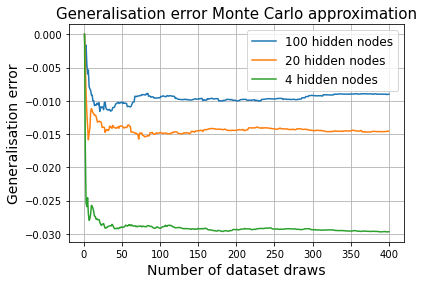

In [189]:
# cont_ge120 = np.zeros(len(cont_kl_div120))
cont_ge100 = np.zeros(len(cont_kl_div100))
cont_ge20 = np.zeros(len(cont_kl_div20))
cont_ge4 = np.zeros(len(cont_kl_div4))
for i in range(len(cont_kl_div4)):
#     cont_ge120[i] = sum(cont_kl_div120[:i])/(i+1)
    cont_ge100[i] = sum(cont_kl_div100[:i])/(i+1)
    cont_ge20[i] = sum(cont_kl_div20[:i])/(i+1)
    cont_ge4[i] = sum(cont_kl_div4[:i])/(i+1)
    
i = np.linspace(1,len(cont_kl_div4),len(cont_kl_div4))
# plt.plot(i,cont_ge120,label = '120 hidden nodes')#,color='b')
plt.plot(i,cont_ge100,label = '100 hidden nodes')#,color='orange')
plt.plot(i,cont_ge20,label = '20 hidden nodes')#,color='g')
plt.plot(i,cont_ge4,label = '4 hidden nodes')#,color='g')
plt.grid()
plt.xlabel('Number of dataset draws',fontsize = 14)
plt.ylabel('Generalisation error',fontsize = 14)
plt.title('Generalisation error Monte Carlo approximation',fontsize = 15)
plt.legend(fontsize = 12)
plt.savefig('cont_Generalization_error_Monte_Carlo_approximation_4_20_100_120_discreteKL1')


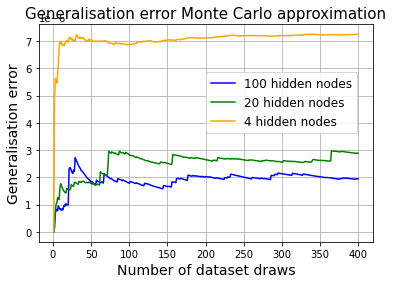

In [260]:
# mse_ge120 = np.zeros(len(mse_120))
mse_ge100 = np.zeros(len(mse_100))
mse_ge20 = np.zeros(len(mse_20))
mse_ge4 = np.zeros(len(mse_4))
for i in range(len(mse_4)):
#     mse_ge120[i] = sum(mse_120[:i])/(i+1)
    mse_ge100[i] = sum(mse_100[:i])/(i+1)
    mse_ge20[i] = sum(mse_20[:i])/(i+1)
    mse_ge4[i] = sum(mse_4[:i])/(i+1)
    
i = np.linspace(1,len(mse_4),len(mse_4))
# plt.plot(i,mse_ge120,label = '120 hidden nodes')#,color='b')
plt.plot(i,mse_ge100,label = '100 hidden nodes',color='blue')
plt.plot(i,mse_ge20,label = '20 hidden nodes',color='green')
plt.plot(i,mse_ge4,label = '4 hidden nodes',color='orange')
plt.grid()
plt.xlabel('Number of dataset draws',fontsize = 14)
plt.ylabel('Generalisation error',fontsize = 14)
plt.title('Generalisation error Monte Carlo approximation',fontsize = 15)
plt.legend(fontsize = 12,loc=(0.5,0.5))
plt.savefig('mse_generalization_error_Monte_Carlo_approximation_4_20_100_120_discreteKL1')
